## <b> Лабораторная работа 4 </b> <br>
## Изучение принципов символьного обучения с использованием KAN <br>
#### Зиберов Александр ИНС-м-о-25-1 <br>

#### <b> Цель работы: </b> Изучение принципов обучения KAN при фиксированных символьных функциях активации, а также освоение подхода к связыванию B-сплайнов с заданными символьными формулами для последующего обучения остальной части сети.

In [16]:
# Импорт библиотек
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
from utils import eval_basis_functions, get_coeff, single_stacked_kan_training

## Набор данных

Создадим набор данных, используя пример функции: $ f(x, y) = e^{\sin(\pi x) + (y+0,5)^2} $.

In [17]:
# Определяем целевую функцию:
fn = lambda x: torch.exp(torch.sin(torch.pi * x[:, :1]) + torch.pow(x[:, 1:] + 0.5, 2))

# Создаём равномерную сетку значений x1 и x2 в диапазоне [-1, 1]
x1 = torch.linspace(-1, 1, steps=40)
x2 = torch.linspace(-1, 1, steps=40)

# Формируем двумерную сетку координат
x1, x2 = torch.meshgrid(x1, x2, indexing='ij')

# Объединяем координаты в один тензор для подачи в функцию fn
x_eval = torch.stack([x1.flatten(), x2.flatten()], dim=1)

# Вычисляем значения функции для всех точек сетки
y_target = fn(x_eval)
# при необходимости можно добавить шум: + torch.randn(...) * 0.1

# Делим данные на обучающую (80%) и тестовую (20%) выборки
n_training = int(x_eval.shape[0] * 0.8)
training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]

x_training = x_eval[training_idxs]
x_test = x_eval[test_idxs]
y_training = y_target[training_idxs]
y_test = y_target[test_idxs]

print("Обучающая выборка: ", n_training)
print("Тестовая выборка: ", len(test_idxs))

Обучающая выборка:  1280
Тестовая выборка:  743


## Основные функции

Определим базовые функции, среди которых:
1. `initialize_KAN` для настройки KAN с использованием предоставленных параметров.
2. `eval_KAN` для оценки KAN для заданного x
3. `eval_x_symbolically` для вычисления x с учетом только символических функций.
4. `set_symbolic_fn` для установки конкретной функции активации в KAN на указанную символьную функцию.

In [18]:
def initialize_KAN(KAN, k, grid_range, grid_size):
    """
    Инициализирует структуру KAN: коэффициенты, маски и символьные функции.
    
    Args:
        KAN: список количества нейронов в каждом слое (например, [2, 3, 1])
        k: порядок B-сплайна
        grid_range: диапазон сетки (например, [-1, 1])
        grid_size: количество контрольных точек
    """
    # Создаем равномерную сетку значений для всех сплайнов
    grid = torch.linspace(grid_range[0], grid_range[1], steps=grid_size).unsqueeze(dim=0)
    
    # Инициализация коэффициентов, масок и символьных функций
    coefs, masks, symbolic_functions = [], [], []
    for in_dim, out_dim in zip(KAN, KAN[1:]):
        # Коэффициенты для B-сплайнов (параметры, которые будут обучаться)
        coef = torch.zeros((in_dim, out_dim, grid_size + k - 1), requires_grad=True)
        
        # Маска: 1 — использовать сплайн, 0 — использовать символьную функцию
        mask = torch.ones((in_dim, out_dim))
        
        coefs.append(coef)
        masks.append(mask)
    
        # Символьные функции по умолчанию — тождественные (f(x) = x)
        symb_fns = [[lambda x: x for _ in range(out_dim)] for _ in range(in_dim)]
        symbolic_functions.append(symb_fns)
        
    return coefs, masks, symbolic_functions, grid

In [19]:
def eval_KAN(x, coefs, masks, symbolic_functions, grid, k):
    """
    Выполняет прямой проход (forward) по сети KAN.
    
    Args:
        x: входные данные (Batch x входные_размерности)
        coefs: список коэффициентов B-сплайнов
        masks: маски для переключения между сплайном и символической функцией
        symbolic_functions: символьные функции для каждой связи
        grid: сетка для вычисления B-сплайнов
        k: порядок B-сплайна
    """
    x_in = x
    for coef, mask, symb_fns in zip(coefs, masks, symbolic_functions):
        # Вычисляем базисные функции для текущего входа
        bases = eval_basis_functions(x_in, grid, k)

        # Вычисляем выход сплайновых активаций
        y_sp = torch.einsum('ijk, bik -> bij', coef, bases)

        # Вычисляем выход символических функций
        y_symb = eval_x_symbolically(x_in, symb_fns)

        # Объединяем оба выхода в зависимости от маски
        y = mask[None, ...] * y_sp + (1 - mask[None, ...]) * y_symb

        # Суммируем по входным нейронам — получаем выход слоя
        x_in = y.sum(dim=1)  # Размер: Batch × выходной_размер

    return x_in

In [20]:
def eval_x_symbolically(x_eval, symbolic_fns):
    """
    Вычисляет результат применения заданных символьных функций к входным данным.

    Args:
        x_eval: входные данные (Batch × число признаков)
        symbolic_fns: список символьных функций для каждой связи
    """
    in_dim = len(symbolic_fns)
    out_dim = len(symbolic_fns[0])
    postacts = []

    # Применяем символьные функции для каждой пары вход-выход
    for i in range(in_dim):
        postacts_ = []
        for j in range(out_dim):
            symb_fn = symbolic_fns[i][j]
            postacts_.append(symb_fn(x_eval[:, i]))
        postacts.append(torch.stack(postacts_, dim=1))
    
    # Возвращаем стек, чтобы сохранить размерность входных признаков
    return torch.stack(postacts, dim=1)

In [21]:
def set_symbolic_fn(symbolic_functions, masks, i, j, k, fn, use_affine=False):
    """
    Устанавливает конкретную символьную функцию активации для связи (i, j, k).
    
    Args:
        symbolic_functions: текущий список символьных функций
        masks: маски активаций
        i: индекс слоя
        j: индекс входного нейрона
        k: индекс выходного нейрона
        fn: функция, которую нужно установить
        use_affine: использовать ли SymbolicKANLayer (если True — добавляется линейное преобразование)
    """
    # Выбираем способ применения функции
    if use_affine:
        symb_fn = SymbolicKANLayer(fn)
    else:
        symb_fn = fn

    # Присваиваем новую символьную функцию
    symbolic_functions[i][j][k] = symb_fn

    # Отключаем сплайн для этой связи (маска = 0)
    masks[i].data[j][k] = 0

    return symbolic_functions, masks

### 1. Обучение KAN без символических формул

Обучим KAN без каких-либо символических функций.

Чтобы эффективно смоделировать функцию с помощью KAN, необходимо настроить функции активации следующим образом:

1. **Сопоставление $ y $ с $ y^2 $**: эта функция возводит в квадрат значение $ (y + 0,5)^2 $.
2. **Сопоставление $ x $ с $ \sin(\pi x) $**: Эта функция будет применять синусоидальное преобразование, масштабированное $ \pi $, к $ x $.
3. **Объединение результатов**: сложите результаты 1 и 2, чтобы получить новое промежуточное значение $z$.
4. **Экспоненциальная активация**: сопоставьте $z$ с $e^z$, вычисляя экспоненту от $z$.

Эта последовательность требует структуры KAN [2, 1, 1]:
- Два входа ($x$ и $y$) сначала преобразуются в один промежуточный выход $z$,
- Затем $z$ преобразуется в конечный результат $e^z$.

Чтобы облегчить пакетную обработку, мы используем «маску» (mask):
- Если mask=1, модель применяет функции активации сплайна.
- Если mask=0, модель использует предопределенные символьные функции.

In [22]:
# Настройка параметров KAN
k = 3                     # порядок B-сплайна
grid_range = [-1, 1]      # диапазон сетки
grid_size = 10            # количество контрольных точек
KAN = [2, 1, 1]           # структура сети: 2 входа -> 1 скрытый -> 1 выход

# Инициализация коэффициентов, масок и символьных функций
coefs, masks, symbolic_functions, grid = initialize_KAN(KAN, k, grid_range, grid_size)

# Гиперпараметры обучения
lr = 0.01                                 # скорость обучения
early_stopping_iterations = 1e4           # максимальное количество итераций
early_stopping_imrpovement_threshold = 200  # количество итераций без улучшения, после которого обучение остановится

# Словарь для сохранения истории ошибок
losses = {'train': [], 'val': []}
i = 0
verbose = True
best_loss = np.inf  # начальное лучшее значение ошибки

# Основной цикл обучения
while True: 
    # Случайно перемешиваем индексы для стохастического обучения
    shuffled_idxs = torch.randperm(x_training.shape[0])
    
    # Прямое распространение: прогноз на обучающем наборе
    y_pred = eval_KAN(x_training[shuffled_idxs], coefs, masks, symbolic_functions, grid, k)
    
    # Вычисляем функцию потерь (среднеквадратичная ошибка)
    loss = torch.mean(torch.pow(y_pred - y_training[shuffled_idxs], 2))
    loss.backward()  # обратное распространение ошибки
    losses['train'].append(loss.item())

    # Обновление коэффициентов KAN по правилу градиентного спуска
    for coef in coefs:
        if coef.grad is not None:
            coef.data = coef.data - lr * coef.grad  # шаг обновления
            coef.grad.zero_()                      # обнуляем градиенты

    # Проверка на тестовом наборе
    with torch.no_grad():
        y_test_pred = eval_KAN(x_test, coefs, masks, symbolic_functions, grid, k)
        val_loss = torch.mean(torch.pow(y_test_pred - y_test, 2))

    losses['val'].append(val_loss.item())

    # Каждые 100 итераций выводим текущие результаты
    if i % 100 == 0 and verbose:
        print(f"Val loss: {val_loss.item(): 0.5f}\tTrain loss: {loss.item(): 0.5f}\tBest Val loss: {best_loss: 0.5f}")
        
    # Ранняя остановка при отсутствии улучшений
    if best_loss > val_loss.item():
        best_loss = val_loss.item()
        best_model = (coefs, masks, symbolic_functions)
        n_no_improvements = 0
    else:
        n_no_improvements += 1
        if n_no_improvements > early_stopping_imrpovement_threshold:
            print('Остановка: улучшений больше нет...')
            break

    # Проверка предельного числа итераций
    i += 1
    if i > early_stopping_iterations:
        print('Остановка: достигнут предел итераций...')
        break


Val loss:  19.25048	Train loss:  23.81689	Best Val loss:  inf
Val loss:  7.14150	Train loss:  8.96728	Best Val loss:  7.04464
Val loss:  15.02930	Train loss:  9.53792	Best Val loss:  5.02589
Val loss:  3.19676	Train loss:  4.23850	Best Val loss:  3.18045
Val loss:  3.37301	Train loss:  5.74101	Best Val loss:  2.60277
Val loss:  7.69867	Train loss:  5.19996	Best Val loss:  2.18344
Val loss:  7.07808	Train loss:  7.84063	Best Val loss:  1.83091
Val loss:  4.90511	Train loss:  8.70542	Best Val loss:  1.68252
Val loss:  3.06717	Train loss:  2.83835	Best Val loss:  1.44917
Val loss:  3.58194	Train loss:  2.85989	Best Val loss:  1.41086
Val loss:  3.34367	Train loss:  4.19081	Best Val loss:  1.21183
Val loss:  2.57813	Train loss:  2.14445	Best Val loss:  1.05267
Val loss:  1.99249	Train loss:  2.79611	Best Val loss:  1.05267
Val loss:  1.73173	Train loss:  2.42620	Best Val loss:  1.04490
Val loss:  2.27108	Train loss:  4.34065	Best Val loss:  1.04490
Остановка: улучшений больше нет...


#### Визуализация отдельных функций активации
Визуализируем активации на первом и втором уровне сети, чтобы увидеть, как KAN реагирует на входные переменные x1 и x2.

validation loss:  1.04490


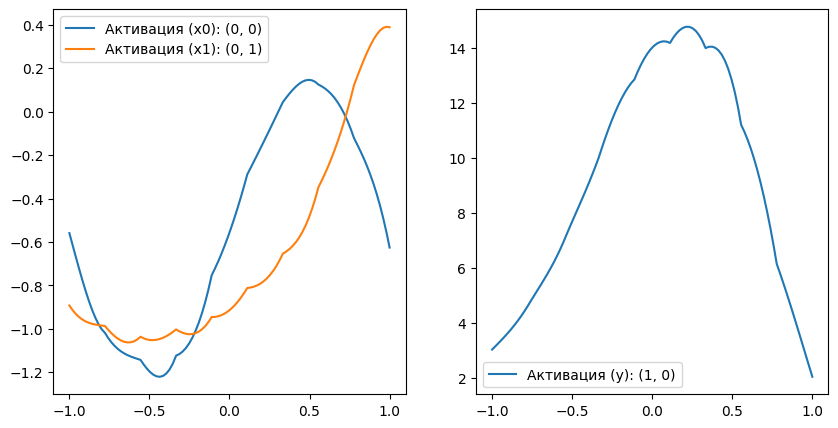

In [23]:
coefs, masks, symbolic_functions = best_model
print(f"validation loss: {best_loss: 0.5f}")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)

x = torch.linspace(-1, 1, steps=100).unsqueeze(dim=1)
bases = eval_basis_functions(x, grid, k=3)

ax = axs[0]
y_out_0 = torch.einsum('ijk, bij->bk', coefs[0][0:1].transpose(2, 1), bases)
y_out_1 = torch.einsum('ijk, bij->bk', coefs[0][1:2].transpose(2, 1), bases)
ax.plot(x.numpy(), y_out_0.detach().numpy(), label="Активация (x0): (0, 0)")
ax.plot(x.numpy(), y_out_1.detach().numpy(), label="Активация (x1): (0, 1)")
ax.legend()

ax = axs[1]
y_out_final = torch.einsum('ijk, bij->bk', coefs[1].transpose(2, 1), bases)
ax.plot(x.numpy(), y_out_final.detach().numpy(), label="Активация (y): (1, 0)")

ax.legend()

При просмотре графиков видно, что реакция функции на x1 напоминает квадратичную зависимость. Это значит, что модель фактически сама «выучила» что-то близкое к функции $ y = x^2 $. На основе этого наблюдения, можно зафиксировать эту активацию как квадратичную — то есть явно задать форму функции, вместо того чтобы сеть подбирала её самостоятельно. Это может потенциально упростить модель и повысит её интерпретируемость.

### 2. Обучение KAN с активацией, привязанной к идентифицированной символьной формуле

Зафиксируем $y$ в виде символической формулы $y^2$ или ее обучаемого варианта и реализуем это следующим образом:
1. Мы определяем символические слои, которые содержат потенциальную символическую функцию для этой функции активации.
2. Прикрепив к формуле функцию активации, мы заменяем эту функцию. Мы также модифицируем маску, чтобы указать, где следует использовать функцию символической активации. 
3. При дальнейшем развитии модели мы вычисляем все выходные данные для символического слоя, используя выходные данные предыдущего слоя. 
4. Наконец, мы объединяем результаты, используя маску.

В нашем примере есть два измерения на входе и три измерения на выходе, т. е. слой, который принимает 2 измерения на входе и выводит 3 измерения. В результате мы имеем 2х3 активации, а значит и символические функции.

### Пакетная обработка (batch processing)

Чтобы включить фиксированную символическую формулу, например $ ((y + 0,5)^2) $, в модель KAN, мы выполним следующие шаги:

1. Определение символических слоёв - создаются слои, которые могут содержать потенциальные символические функции для каждой активации. Это позволяет напрямую встраивать известные математические зависимости.
2. Замена функции активации - корректируется «маска», чтобы обозначить области, где следует использовать символическую активацию.
3. Прямой проход модели - во время прямого прохода вычисляются выходные данные символического слоя на основе результатов предыдущего слоя, что обеспечивает корректное применение фиксированных преобразований.
4. Объединение выходных данных - с помощью маски объединяются результаты символьных и сплайновых активаций.

### 2.1. Аффинные преобразования символьных функций

Авторы идей KAN предложили использовать функции символьной активации, чтобы для заданной функции достаточно было изучить аффинные преобразования ввода и вывода, чтобы точно ее предсказать. Идея заключается в том, что для заданной символической функции достаточно изучить лишь линейные преобразования входа и выхода, чтобы сеть точно аппроксимировала её поведение.

Аффинные преобразования - это линейные преобразования с добавлением сдвига.
В общем виде аффинная функция задается как:
$$
y = a \cdot x + b
$$
где $ x $ - входное значение, $ a $ - коэффициент масштабирования (растягивание/сжатие), $ b $ - сдвиг (смещение).

Реализуем класс SymbolicKANLayer, который создаёт символьный слой с аффинными преобразованиями входа и выхода.

In [24]:
class SymbolicKANLayer(nn.Module):
    def __init__(self, fn):
        """
        Символьный слой с аффинными преобразованиями.
        
        Args:
            fn: заданная символическая функция активации (например, y^2)
        """
        super().__init__()
        self.fn = fn
        
        # Параметры аффинного преобразования [scale_out, scale_in, shift_in, shift_out]
        self.affine = torch.nn.Parameter(torch.zeros(4), requires_grad=True)
        
    def forward(self, x_eval):
        """
        Прямой проход слоя: применяем символическую функцию
        с аффинным преобразованием входа и выхода.
        """
        return self.affine[0] * self.fn(self.affine[1]*x_eval + self.affine[2]) + self.affine[3]

    def step(self, lr):
        """
        Один шаг градиентного спуска для параметров аффинного преобразования.
        """
        if self.affine.grad is not None:
            self.affine.data = self.affine.data - lr * self.affine.grad

    def zero_grad_(self):
        """
        Обнуляет градиенты параметров аффинного преобразования.
        """
        self.affine.grad.zero_()


Выполним обучение KAN с фиксированной символической функцией $(x+0.5)^2$ для активации x1. Инициализируются коэффициенты сплайнов, маски и символические функции, после чего проводится цикл обучения с вычислением MSE для обучающего и тестового наборов, обновлением коэффициентов и параметров символических слоев.

In [25]:
# Настройка KAN
k = 3                     # порядок сплайна
grid_range = [-1, 1]      # диапазон контрольных точек
grid_size = 10             # количество контрольных точек
KAN = [2, 1, 1]            # структура сети: 2 входа -> 1 скрытый -> 1 выход

# Инициализация коэффициентов, масок и символических функций
coefs, masks, symbolic_functions, grid = initialize_KAN(KAN, k, grid_range, grid_size)

# Гиперпараметры обучения
lr = 0.01
early_stopping_iterations = 1e4
early_stopping_imrpovement_threshold = 200

# Настройка символических функций
# symbolic_functions, masks = set_symbolic_fn(symbolic_functions, masks, 0, 0, 0, lambda x: torch.sin(torch.pi * x), use_affine=False)
# symbolic_functions, masks = set_symbolic_fn(symbolic_functions, masks, 0, 0, 0, lambda x: torch.sin(x), use_affine=True)
# symbolic_functions, masks = set_symbolic_fn(symbolic_functions, masks, 0, 1, 0, lambda x: torch.pow(x, 2), use_affine=True)
# symbolic_functions, masks = set_symbolic_fn(symbolic_functions, masks, 1, 0, 0, lambda x: torch.exp(x), use_affine=False)

# Здесь мы фиксируем активацию x1 как (x + 0.5)^2
symbolic_functions, masks = set_symbolic_fn(
    symbolic_functions, masks, 
    i=0, j=1, k=0, 
    fn=lambda x: torch.pow(x + 0.5, 2), 
    use_affine=False
)

# Словари для хранения ошибок обучения и проверки
losses_symb = {'train': [], 'val': []}
i = 0
verbose = True
best_loss = np.inf

# Основной цикл обучения
while True:    
    # Случайная перестановка индексов
    shuffled_idxs = torch.randperm(x_training.shape[0])
    x = x_training[shuffled_idxs]

    # Прямой проход через KAN
    y_pred = eval_KAN(x, coefs, masks, symbolic_functions, grid, k)

    # Вычисление ошибки (MSE)
    loss = torch.mean(torch.pow(y_pred - y_training[shuffled_idxs], 2))
    loss.backward()
    losses_symb['train'].append(loss.item())

    # Обновление коэффициентов сплайнов
    for coef in coefs:
        if coef.grad is not None:
            coef.data = coef.data - lr * coef.grad
            coef.grad.zero_()

    # Обновление параметров символических слоев
    for symb_layer in symbolic_functions:
        for neuron in symb_layer:
            for out_symb in neuron:
                if isinstance(out_symb, SymbolicKANLayer):
                    out_symb.step(lr)     # шаг градиентного спуска
                    out_symb.zero_grad_() # обнуление градиентов

    # Проверка на тестовом наборе
    with torch.no_grad():
        y_test_pred = eval_KAN(x_test, coefs, masks, symbolic_functions, grid, k)
        val_loss = torch.mean(torch.pow(y_test_pred - y_test, 2))
    losses_symb['val'].append(val_loss.item())
    
    # Вывод прогресса каждые 100 итераций
    if i % 100 == 0 and verbose:
        print(f"Val loss: {val_loss.item():0.5f}\tTrain loss: {loss.item():0.5f}\tBest Val loss:{best_loss:0.5f}")

    # Сохранение лучшей модели
    if best_loss > val_loss.item():
        best_loss = val_loss.item()
        best_model = (coefs, masks, symbolic_functions)
        n_no_improvements = 0
    else:
        n_no_improvements += 1
        # Раннее завершение при отсутствии улучшений
        if n_no_improvements > early_stopping_imrpovement_threshold:
            print('Остановка: Нет дальнейших улучшений!')
            break

    i += 1
    # Ограничение по количеству итераций
    if i > early_stopping_iterations:
        print('Остановка: Лимит итераций достигнут...')
        break


Val loss: 20.61320	Train loss: 23.81689	Best Val loss:inf
Val loss: 12.99998	Train loss: 15.40071	Best Val loss:13.14363
Val loss: 7.02954	Train loss: 8.62432	Best Val loss:7.07370
Val loss: 4.49161	Train loss: 5.70732	Best Val loss:4.45877
Val loss: 3.27310	Train loss: 4.23968	Best Val loss:3.17284
Val loss: 2.37884	Train loss: 3.22556	Best Val loss:2.39829
Val loss: 1.69875	Train loss: 2.98756	Best Val loss:1.78267
Val loss: 1.39862	Train loss: 2.15026	Best Val loss:1.41447
Val loss: 1.15217	Train loss: 1.53390	Best Val loss:1.12368
Val loss: 0.97391	Train loss: 1.65985	Best Val loss:0.97269
Val loss: 0.87389	Train loss: 1.29474	Best Val loss:0.84958
Val loss: 0.77193	Train loss: 1.15204	Best Val loss:0.77507
Val loss: 0.70115	Train loss: 0.99838	Best Val loss:0.70212
Val loss: 0.65024	Train loss: 0.91317	Best Val loss:0.65185
Val loss: 0.60863	Train loss: 0.82015	Best Val loss:0.60886
Val loss: 0.58034	Train loss: 0.75972	Best Val loss:0.58110
Val loss: 0.55598	Train loss: 0.70789	B

Визуализируем функции активации KAN после обучения. На первом графике показываем сплайновые активации для входов x0 и x1, на втором - выходную активацию y.

validation loss: 0.42720


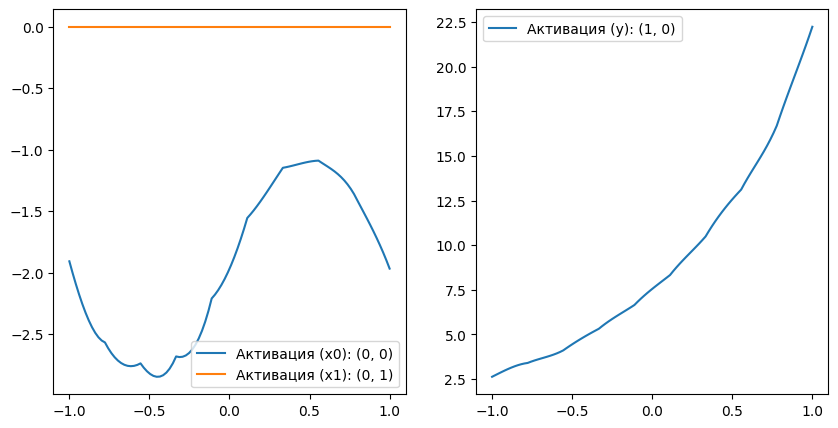

In [26]:
# Извлечение лучшей модели после обучения
coefs, masks, symbolic_functions = best_model
print(f"validation loss: {best_loss:0.5f}")  # Вывод ошибки на валидации

# Создание фигуры с 2 графиками
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)

# Сетка для визуализации функций активации
x = torch.linspace(-1, 1, steps=100).unsqueeze(dim=1)
bases = eval_basis_functions(x, grid, k=3)  # вычисляем базисные функции сплайнов

# Визуализация активаций первого слоя (x0 и x1)
ax = axs[0]
y_out_0 = torch.einsum('ijk, bij->bk', coefs[0][0:1].transpose(2, 1), bases)
y_out_1 = torch.einsum('ijk, bij->bk', coefs[0][1:2].transpose(2, 1), bases)
ax.plot(x.numpy(), y_out_0.detach().numpy(), label="Активация (x0): (0, 0)")
ax.plot(x.numpy(), y_out_1.detach().numpy(), label="Активация (x1): (0, 1)")
ax.legend()

# Визуализация активации второго слоя (выходной слой y)
ax = axs[1]
y_out_final = torch.einsum('ijk, bij->bk', coefs[1].transpose(2, 1), bases)
ax.plot(x.numpy(), y_out_final.detach().numpy(), label="Активация (y): (1, 0)")
ax.legend()

Кривая для (x2\) всюду равна нулю, поскольку коэффициенты для \(x2\) не получили никаких градиентов. Этот результат ожидаем, поскольку мы маскируем все выходные данные, связанные с \(x2\), с помощью его символьной функции. Остальные функции активации корректно обучаются и отражают заданные функциональные зависимости.

Построим график ошибки обучения и валидации для KAN с фиксированной символической функцией и без неё:

Text(0.5, 1.0, 'Ошибка (Loss)')

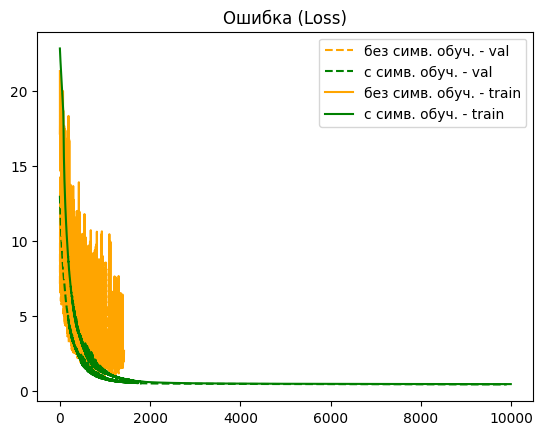

In [27]:
# График ошибок на валидационном наборе
plt.plot(losses['val'][100:], label='без симв. обуч. - val', linestyle='--', alpha=1.0, color='orange')
plt.plot(losses_symb['val'][100:], label='с симв. обуч. - val', linestyle='--', alpha=1.0,  color='green')

# График ошибок на обучающем наборе
plt.plot(losses['train'][10:], label='без симв. обуч. - train', linestyle='-', alpha=1.0, color='orange')
plt.plot(losses_symb['train'][10:], label='с симв. обуч. - train', linestyle='-', alpha=1.0, color='green')

# Добавление легенды и заголовка графика
plt.legend()
plt.title('Ошибка (Loss)')

### Выводы

- Уменьшение количества контрольных точек в сетке делает сплайны менее гибкими и снижает точность аппроксимации.
- Закрепление известных зависимостей, например $\sin(\pi x)$ или $(x+0.5)^2$, ускоряет обучение и повышает точность модели.
- Неверная фиксация символической функции может ухудшить результаты, особенно при простой структуре KAN, когда другие активации не способны компенсировать ошибку.
- В условиях шума фиксированные функции могут вызвать переобучение других активаций, но позволяют лучше понять влияние отдельных переменных и повышают интерпретируемость модели.

Как итог, использование символических функций помогает сделать модель более точной и понятной, но требует внимательного выбора закрепляемых формул.

## Вывод

В ходе работы изучены методы закрепления символьных функций активации в KAN. Показано, как фиксирование известных формул упрощает обучение и повышает точность модели, а также освоен подход связывания B-сплайнов с символьными функциями для эффективного обучения остальной части сети.